In [25]:
from skimage import io, img_as_float, img_as_ubyte
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy import signal
from math import log10
import matplotlib.pyplot as plt
import numpy as np
import json
import math

In [26]:
def MED(actual, predicted):
    errors = np.abs(actual - predicted)
    return np.median(errors)

def NMED(actual, predicted):
    errors = np.abs(actual - predicted)
    return np.median(errors) / (np.max(actual) - np.min(actual))

def MRED(actual, predicted):

    abs_error = np.abs(predicted - actual)
    actual = actual + 0.0001
    # Calculate the relative error
    rel_error = abs_error / actual
    
    # Calculate the mean relative error
    mean_rel_error = np.mean(rel_error)
    
    return mean_rel_error
    # errors = np.abs(actual - predicted)
    # return np.mean(errors / actual)

/home/fsengi/Documents/master/epc/epcExercise/.venv/lib/python3.10/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)


Error plot at: indexBit 0 Algo exact Serial [1] - cannot convert float infinity to integer
Error plot at: indexBit 1 Algo exact Serial [1] - cannot convert float infinity to integer
Error plot at: indexBit 2 Algo exact Serial [1] - cannot convert float infinity to integer
Error plot at: indexBit 3 Algo exact Serial [1] - cannot convert float infinity to integer
Error plot at: indexBit 4 Algo exact Serial [1] - cannot convert float infinity to integer
Error plot at: indexBit 5 Algo exact Serial [1] - cannot convert float infinity to integer
Error plot at: indexBit 6 Algo exact Serial [1] - cannot convert float infinity to integer
Error plot at: indexBit 7 Algo exact Serial [1] - cannot convert float infinity to integer
Error plot at: indexBit 0 Algo exact Semi Serial [7] - cannot convert float infinity to integer
Error plot at: indexBit 1 Algo exact Semi Serial [7] - cannot convert float infinity to integer
Error plot at: indexBit 2 Algo exact Semi Serial [7] - cannot convert float infi

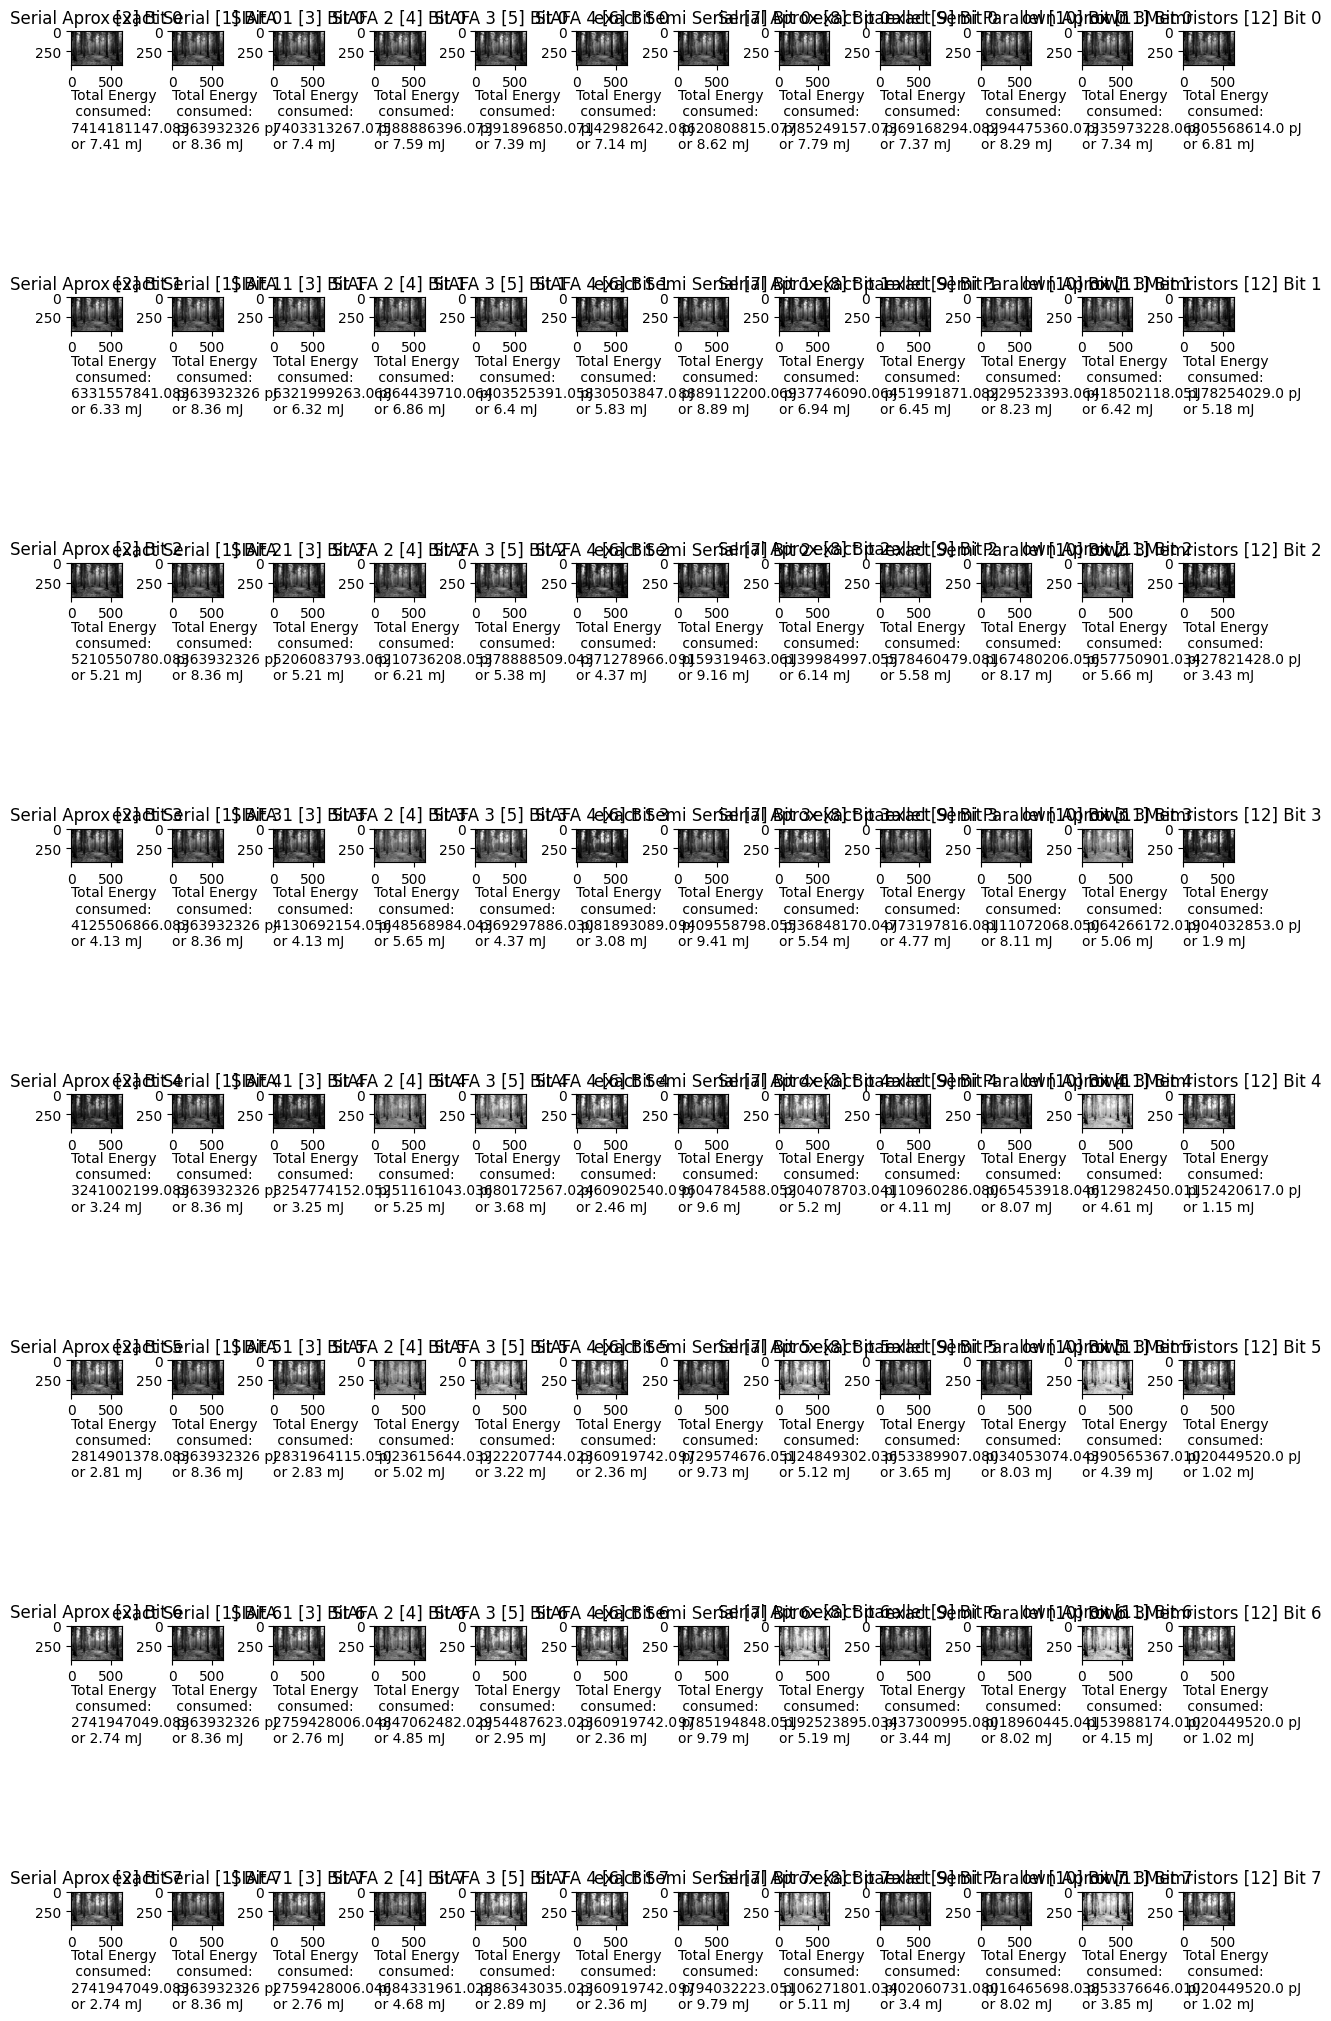

In [27]:
algo_list = ["Serial Aprox [2]","exact Serial [1]", "SIAFA 1 [3]","SIAFA 2 [4]","SIAFA 3 [5]","SIAFA 4 [6]","exact Semi Serial [7]","Serial Aprox [8]", "exact parallel [9]","exact Semi Parallel [10]","own Aprox [11]", "own 3Memristors [12]"]

parsed_data = {}
rows = 8
coll = len(algo_list)
bit_list = range(0,rows)

empty_list = [0]*rows

kernelname_list = []
kernelname_list.append("blurring")
kernelname_list.append("edge_Detection")

for i, name in enumerate(algo_list):
    parsed_data[name] = {"ssi": empty_list, "psnr": empty_list, "energy_con": empty_list, "med": empty_list, "nmed": empty_list, "mred": empty_list}

# load data from jsonfile 
with open('data.json', 'w') as json_file:
    json.dump(parsed_data, json_file, indent=4)

# Load the data from the JSON file into a dictionary
with open('data.json', 'r') as json_file:
    loadedDict = json.load(json_file)


fig, axs = plt.subplots(rows, coll, figsize=(15, 5))  # 5 rows, 1 column
plt.subplots_adjust(left=0.125, bottom=6, right=0.9, top=10, wspace=1, hspace=0.9)

#blurring
# loop throw all Bitpositions 
for indexAlgo, approxAlgo in enumerate(algo_list):
    pic_list = []
    pic_list.append(np.load(f"data_blurring/outputimage_exact Serial [1]_2.npy"))
    energy_list = []
    # loop throw all Algorithm
    for indexBit, approxBit in enumerate(bit_list):
        # show picture in subplot

        with open(f'data_blurring/{approxAlgo}_{indexBit}.json', 'r') as json_file:
            energy_list.append(json.load(json_file))
        
        pic_list.append(np.load(f"data_blurring/outputimage_{approxAlgo}_{indexBit}.npy"))

        # print(pic_list[0])
        
        axs[indexBit,indexAlgo].imshow(pic_list[-1], cmap = "gray")
        # Add an annotation to the subplot
        axs[indexBit,indexAlgo].annotate(f"\nTotal Energy\n consumed: \n{round(energy_list[indexBit],0)} pJ \nor {round(energy_list[indexBit]/10**9,2)} mJ", (0,0), (0,-5),xycoords='axes fraction', textcoords='offset points', va='top')
    
        axs[indexBit,indexAlgo].set_title(f"{approxAlgo} Bit {approxBit}")
       
        try:
            # data_range = pic_list[-1].max() - pic_list[-1].min()  
            # mse = mse(pic_list[0], pic_list[-1])    
            # print(mse) 
            # load results to dictionary
            # print(pic_list[0].max())
            loadedDict[approxAlgo]["ssi"][indexBit] = ssim(pic_list[0], pic_list[-1], data_range=255)
            loadedDict[approxAlgo]["psnr"][indexBit] = round(psnr(pic_list[0], pic_list[-1], data_range=255))
            # loadedDict[approxAlgo]["psnr"][indexBit] = round(10 * log10(pic_list[0].max()**2 / mse),2)
            loadedDict[approxAlgo]["energy_con"][indexBit] = energy_list[-1]/10**3
            loadedDict[approxAlgo]["med"][indexBit] = MED(pic_list[0], pic_list[-1])
            loadedDict[approxAlgo]["nmed"][indexBit] = NMED(pic_list[0], pic_list[-1])
            loadedDict[approxAlgo]["mred"][indexBit] = MRED(pic_list[0], pic_list[-1])
            
        except Exception as e:
            print(f'Error plot at: indexBit {indexBit} Algo {approxAlgo} - {e}')
        else:
            continue
# Show the plot
plt.show()


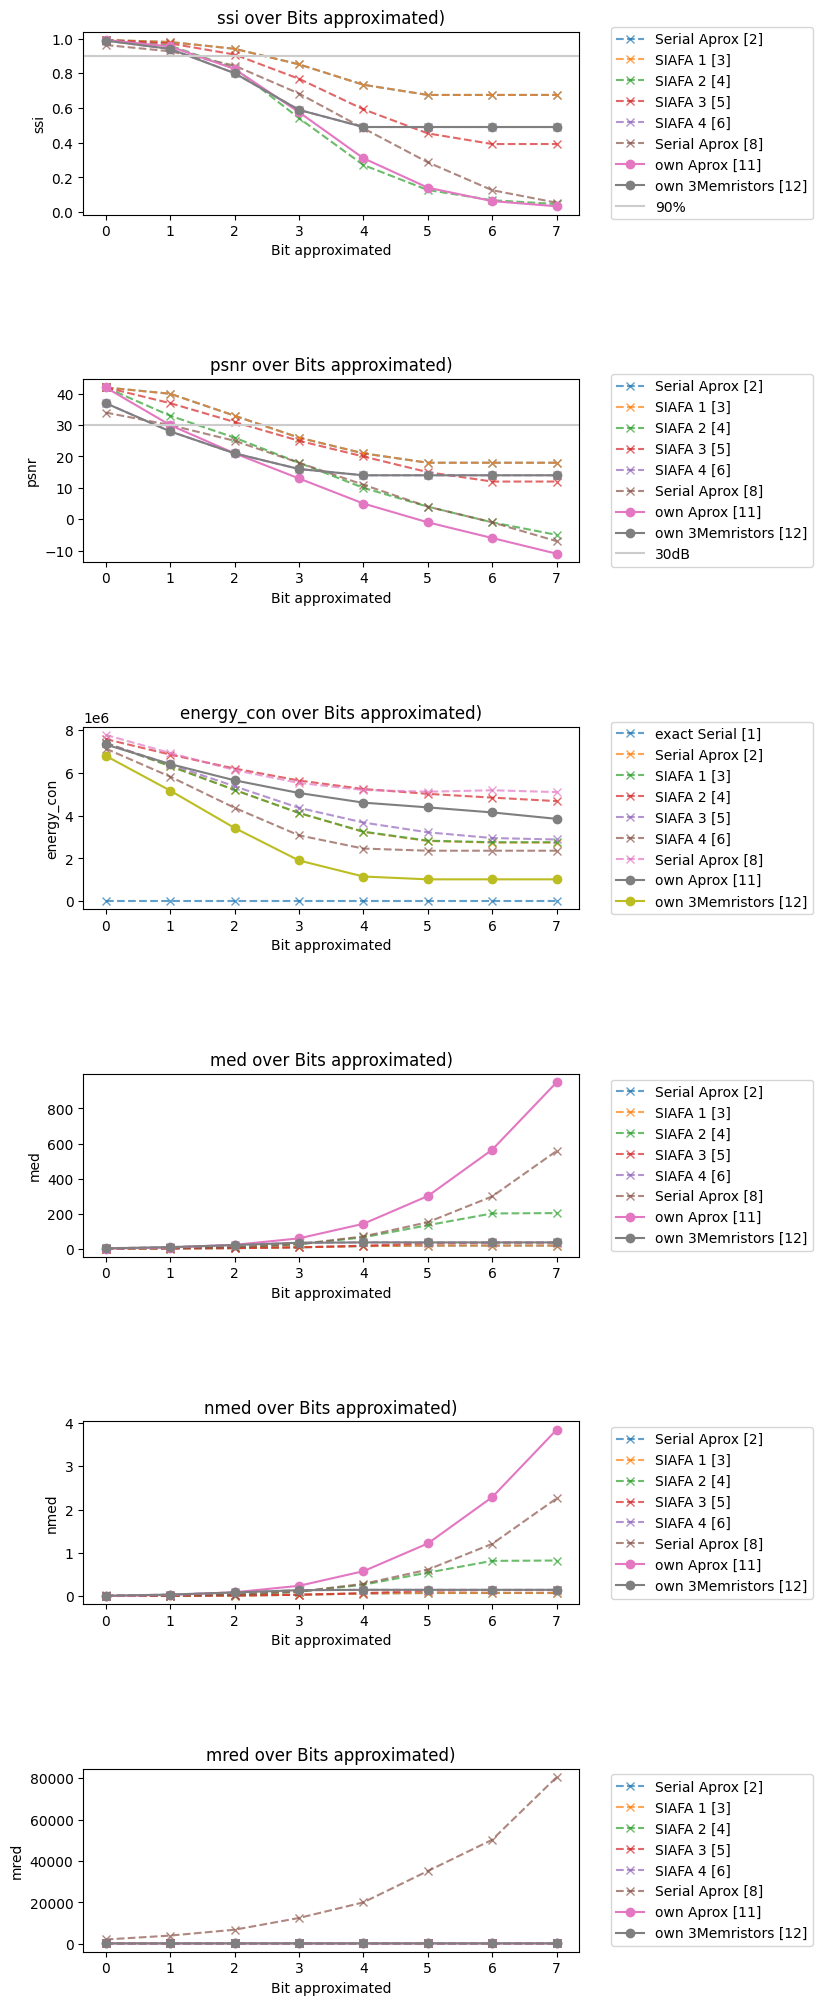

In [28]:
#error metrics list 
algo_list = ["exact Serial [1]","Serial Aprox [2]", "SIAFA 1 [3]","SIAFA 2 [4]","SIAFA 3 [5]","SIAFA 4 [6]","Serial Aprox [8]","own Aprox [11]", "own 3Memristors [12]"]
metrics_list = ["ssi", "psnr", "energy_con", "med", "nmed", "mred"]
rows = len(metrics_list)
coll = 1

fig, axs = plt.subplots(rows, coll )
plt.subplots_adjust(left=0.125, bottom=6, right=0.9, top=10, wspace=1, hspace=0.9)

#blurring
# loop throw all Bitpositions 
for indexMetric, metric in enumerate(metrics_list):

    for indexalgo, algo in enumerate(algo_list):
        if 'own' in algo:
            axs[indexMetric].plot(loadedDict[algo][metric], "o-", label=algo)
        else:
            if metric == 'energy_con' or 'exact' not in algo:
                axs[indexMetric].plot(loadedDict[algo][metric], "x--", label=algo, alpha=0.7)

    if "ssi" in metric:
        axs[indexMetric].axhline(y=0.9, color='0.8', linestyle='-', label='90%')
    if "psnr" in metric:
        axs[indexMetric].axhline(y=30, color='0.8', linestyle='-', label='30dB')

    axs[indexMetric].set_title(f"{metric} over Bits approximated)")
    axs[indexMetric].set_xlabel("Bit approximated")
    axs[indexMetric].set_ylabel(f'{metric}')
    # axs[indexMetric].legend()
    axs[indexMetric].legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

# plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()